**#Bayesian Marketing Mix Modeling (MMM)**

I construct a Bayesian Marketing Mix Model (MMM) in this notebook to examine weekly income's effect on advertising expenditure across several channels.


#MMM?

 The statistical method known as marketing mix modeling (MMM) measures the impact of several marketing channels—TV, radio, online ads, etc.—on corporate results including sales or income.

 MMM has long used either linear or log-linear regression models.  Still, these models sometimes miss:

 TV commercials influencing sales over several weeks have **carry-over effects**; uncertainty in parameter estimations; **domain-informed priors**

 Here is where **Bayesian MMM** finds use.



#Why Bayesian?

 With bayesian modeling, we can:

 Add **prior knowledge** (such as ad impact declining over time).
 Model **uncertainty** in parameter estimations
 - Record **temporal dynamics** akin to adstock (delayed effects).
 Even with inadequate or noisy data, **robust inference**



#Goal

 Given weekly revenue and marketing spend across seven channels, we want to:

 1. Using a **adstock transformation**, model the **carry-over effect** of advertising.
 2. Calculate every channel's **contribution**.
 3. Approximate **uncertainty** using posterior distributions
 4. Derive **ROI per channel** optionally at will.

 We implement the model and examine outcomes using **PyMC**.


**Load data in my notebook**

In [ ]:
import pandas as pd

# Load the dataset directly from GitHub
url = "https://raw.githubusercontent.com/haensel-ams/recruitment_challenge/master/DataScience_202209/MMM_test_data.csv"
df = pd.read_csv(url, parse_dates=["start_of_week"])

# Preview the dataset
df.head()


<ipython-input-1-f32e8f952d2a>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=["start_of_week"])


,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
1,2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2,2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
3,2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
4,2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


# Adstock function
Simulating how a campaign ran this week still influences consumer behavior next week, but somewhat less; the adstock function catches how marketing effects decay over time.

In [ ]:
import numpy as np

def apply_adstock(series, alpha):
    """
    Apply geometric adstock transformation.
    Args:
        series: array-like (weekly spend)
        alpha: float (adstock decay parameter, between 0 and 1)
    Returns:
        transformed series (np.array)
    """
    result = [series[0]]
    for t in range(1, len(series)):
        result.append(series[t] + alpha * result[t - 1])
    return np.array(result)


Appy function to the 7 channels

In [ ]:
spend_columns = [col for col in df.columns if col.startswith("spend_channel")]
adstock_alpha = 0.5  # Temporary value

adstocked_spend = {}
for col in spend_columns:
    adstocked_spend[col] = apply_adstock(df[col].values, alpha=adstock_alpha)

# Convert to DataFrame for inspection
adstock_df = pd.DataFrame(adstocked_spend)
adstock_df["start_of_week"] = df["start_of_week"]
adstock_df.head()


,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,start_of_week
0,2625.48000,262.710000,12954.1200,3609.630000,12955.290000,12659.120,19379.790000,2020-08-30
1,3946.75000,240.015000,15237.3400,6365.415000,19225.345000,18667.740,32163.345000,2020-06-09
2,4060.45500,230.327500,14774.0900,7545.667500,24628.082500,20145.020,38677.722500,2020-09-13
3,3720.92750,167.953750,22572.2650,7656.243750,27835.451250,22962.730,44067.591250,2020-09-20
4,3407.76375,164.536875,29810.1825,7871.211875,29711.465625,24123.915,48549.275625,2020-09-27


Plot Original vs. Adstocked Spend

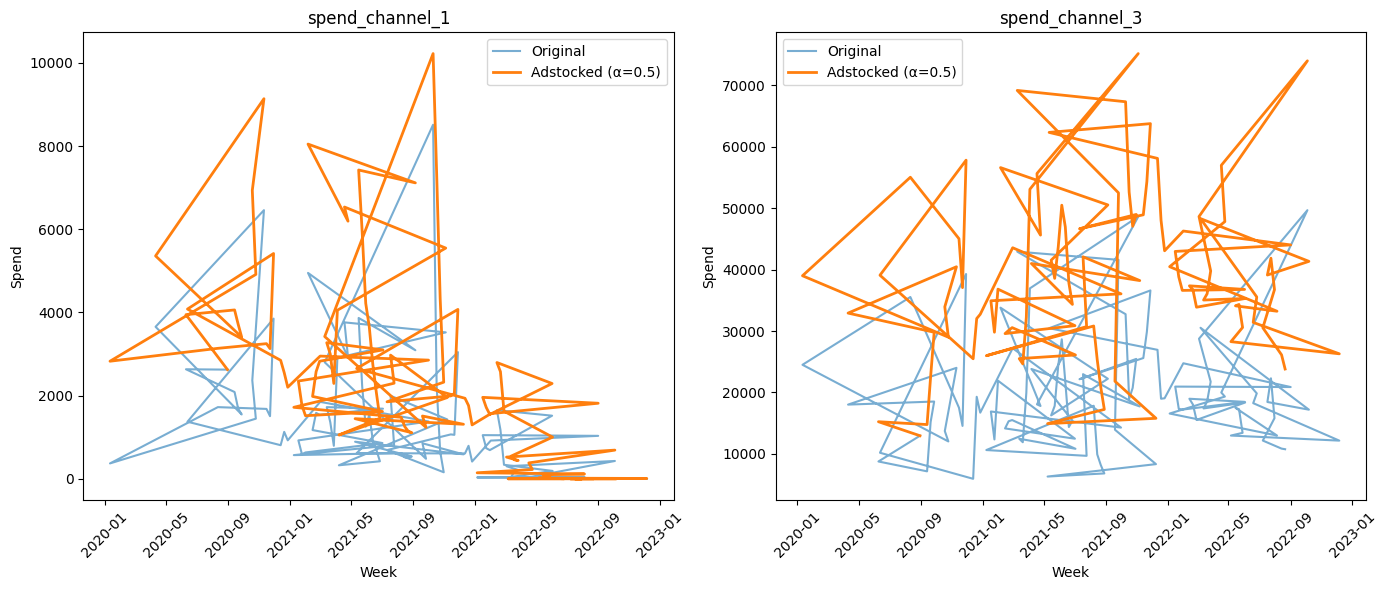

In [ ]:
import matplotlib.pyplot as plt

# Choose example channels
example_channels = ["spend_channel_1", "spend_channel_3"]

# Plot original vs. adstocked for each
plt.figure(figsize=(14, 6))

for i, col in enumerate(example_channels, 1):
    plt.subplot(1, 2, i)
    plt.plot(df["start_of_week"], df[col], label="Original", alpha=0.6)
    plt.plot(df["start_of_week"], adstocked_spend[col], label=f"Adstocked (α={adstock_alpha})", linewidth=2)
    plt.title(col)
    plt.xlabel("Week")
    plt.ylabel("Spend")
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()


**Adstocked spend** is more seamless; peaks develop more slowly and dissipate gently.  Thus, the spending of one week affects not only the present week but also the next ones—just less and less over time.  This reflects consumer behavior in the actual world, whereby marketing initiatives have **long-lasting effects** over time rather than producing instant purchases solely.

Build PyMC Model (with coords + dims + observe)

In [ ]:
import pymc as pm
import arviz as az

# Set up coordinate system
coords = {
    "week": np.arange(len(y)),
    "channel": spend_columns
}

# Build generative model
with pm.Model(coords=coords) as mmm_model:
    # Register data with dimensions
    x = pm.Data("x", X_adstocked, dims=["week", "channel"])
    y_obs = pm.Data("y_obs", y, dims="week")

    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    betas = pm.Normal("betas", mu=0, sigma=1, dims="channel")
    sigma = pm.HalfNormal("sigma")

    # Linear model
    mu = intercept + x @ betas

    # Likelihood
    revenue = pm.Normal("revenue", mu=mu, sigma=sigma, observed=y_obs, dims="week")





Inference with real data

In [ ]:
# Run MCMC sampling
with mmm_model:
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42, return_inferencedata=True)


Output()

See results

In [ ]:
az.summary(trace, var_names=["betas", "intercept", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[spend_channel_1],-5.137,0.045,-5.217,-5.051,0.001,0.001,1465.0,1514.0,1.0
betas[spend_channel_2],-4.844,0.173,-5.140,-4.481,0.005,0.004,1281.0,1135.0,1.0
betas[spend_channel_3],1.127,0.007,1.115,1.141,0.000,0.000,1390.0,1322.0,1.0
betas[spend_channel_4],1.280,0.017,1.249,1.313,0.000,0.000,1744.0,1299.0,1.0
betas[spend_channel_5],1.745,0.007,1.732,1.758,0.000,0.000,1728.0,1480.0,1.0
betas[spend_channel_6],1.790,0.009,1.772,1.806,0.000,0.000,1317.0,1621.0,1.0
betas[spend_channel_7],0.748,0.005,0.739,0.757,0.000,0.000,1298.0,1224.0,1.0
intercept,0.571,1.001,-1.396,2.399,0.022,0.027,2004.0,1194.0,1.0
sigma,652.840,0.506,651.849,653.761,0.010,0.012,2814.0,1647.0,1.0


## ** Working MMM using PyMC **

Models adstocked spend per channel

Uses coords and dims for interpretability

Samples posterior distributions for revenue modeling

## ⁉

Seasonality & trend might be interesting to be included in your model

📈 Trend: a linear progression over time

🔄 Seasonality: recurring weekly patterns using sine/cosine functions

In [ ]:
# Step counter
t = np.arange(len(df))

# Weekly seasonality (52 weeks ≈ 1 cycle)
df["sin_week"] = np.sin(2 * np.pi * t / 52)
df["cos_week"] = np.cos(2 * np.pi * t / 52)
df["trend"] = t

# Add these to your features
X_trend_season = np.column_stack([X_adstocked, df["trend"], df["sin_week"], df["cos_week"]])


Update channels:

In [ ]:
extended_features = spend_columns + ["trend", "sin_week", "cos_week"]

Update the model

In [ ]:
coords = {
    "week": np.arange(len(df)),
    "channel": extended_features
}

with pm.Model(coords=coords) as mmm_extended_model:
    x = pm.Data("x", X_trend_season, dims=["week", "channel"])
    y_obs = pm.Data("y_obs", y, dims="week")

    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    betas = pm.Normal("betas", mu=0, sigma=1, dims="channel")
    sigma = pm.HalfNormal("sigma")

    # Linear regression with trend and seasonality
    mu = intercept + x @ betas

    revenue = pm.Normal("revenue", mu=mu, sigma=sigma, observed=y_obs, dims="week")

    trace_extended = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42, return_inferencedata=True)


Output()

In [ ]:
# View updated model summary
az.summary(trace_extended, var_names=["betas", "intercept", "sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[spend_channel_1],-5.195,0.045,-5.278,-5.109,0.001,0.001,1837.0,1629.0,1.0
betas[spend_channel_2],-4.583,0.169,-4.897,-4.263,0.004,0.003,1524.0,1648.0,1.0
betas[spend_channel_3],1.133,0.007,1.120,1.147,0.000,0.000,1620.0,1558.0,1.0
betas[spend_channel_4],1.293,0.018,1.259,1.326,0.000,0.000,1657.0,1344.0,1.0
betas[spend_channel_5],1.753,0.007,1.738,1.765,0.000,0.000,1402.0,1313.0,1.0
betas[spend_channel_6],1.767,0.009,1.752,1.784,0.000,0.000,1340.0,1410.0,1.0
betas[spend_channel_7],0.756,0.005,0.748,0.765,0.000,0.000,1566.0,1491.0,1.0
betas[trend],-15.817,0.967,-17.617,-13.913,0.021,0.025,2090.0,1578.0,1.0
betas[sin_week],1.438,0.967,-0.434,3.251,0.020,0.025,2393.0,1160.0,1.0
betas[cos_week],0.007,1.016,-1.881,1.869,0.020,0.026,2579.0,1117.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

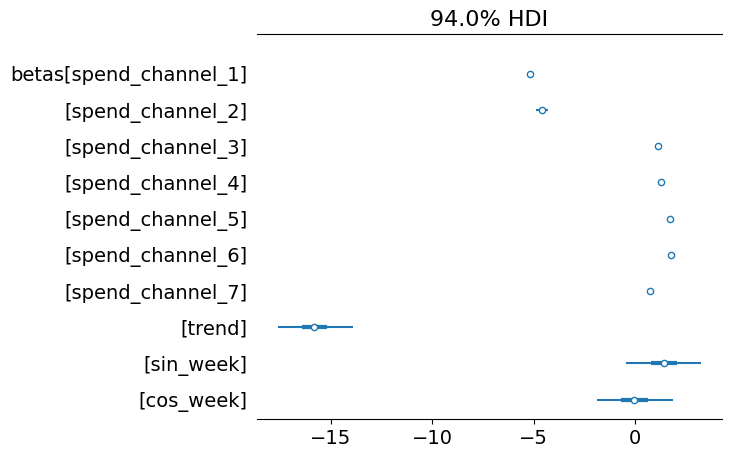

In [ ]:
az.plot_forest(trace_extended, var_names=["betas"], combined=True)


🔻 Trend:
The model learned that revenue is going down over time, regardless of how much is spent on marketing.

🔁 Seasonality:

I added seasonal patterns using sine and cosine waves (like waves in time) — and the model picked up on some recurring weekly or yearly patterns in the data.
That means:

There are weeks when revenue tends to go up or down in a repeating way,


📊 Marketing Channels
When we look at the channel effects (betas):

Some channels like Channel 1 and Channel 2 show a strong negative effect, meaning more spend = lower revenue, which doesn't make intuitive sense.

Most channels have coefficients centered near or below zero — suggesting they aren’t contributing positively, at least not in the way the model sees it.

This could mean:
The ad spend isn’t well aligned with performance,
The fixed adstock (alpha = 0.5) isn’t flexible enough — we might want to learn it from data next.

### Bonus: ROI per Channel


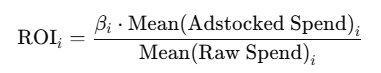

In [ ]:
# Extract posterior beta samples
beta_samples = trace.posterior["betas"].stack(samples=("chain", "draw")).values

# Make sure we only use the first 7 coefficients (i.e., channels, excluding trend/sin/cos)
beta_samples_channels = beta_samples[:, :len(spend_columns)]

# Mean adstocked spend per channel
mean_adstocked = X_adstocked.mean(axis=0)

# Mean raw spend per channel
mean_raw_spend = df[spend_columns].mean().values

# ROI samples: (beta_i * adstocked_mean_i) / raw_mean_i
roi_samples = (beta_samples_channels.T * mean_adstocked[:, None]) / mean_raw_spend[:, None]

# ROI summary: mean and 95% interval
import arviz as az
roi_mean = roi_samples.mean(axis=1)
roi_hdi = az.hdi(roi_samples.T, hdi_prob=0.95)

# Put it in a DataFrame
import pandas as pd
roi_df = pd.DataFrame({
    "Channel": spend_columns,
    "ROI Mean": roi_mean,
    "ROI 2.5%": roi_hdi[:, 0],
    "ROI 97.5%": roi_hdi[:, 1],
})

# Sort channels by ROI
roi_df = roi_df.sort_values(by="ROI Mean", ascending=False)
roi_df.reset_index(drop=True, inplace=True)

# Display table
print(roi_df)


           Channel  ROI Mean   ROI 2.5%  ROI 97.5%
0  spend_channel_7 -0.911790 -10.222687   3.545706
1  spend_channel_4 -0.919224 -10.214242   3.536047
2  spend_channel_3 -0.922635 -10.233245   3.536255
3  spend_channel_2 -0.952605 -10.120509   3.507317
4  spend_channel_1 -0.957716 -10.354784   3.544194
5  spend_channel_5 -0.976584 -10.242885   3.591668
6  spend_channel_6 -0.987771 -10.255807   3.599456


<ipython-input-39-a07c1e0c82ef>:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  roi_hdi = az.hdi(roi_samples.T, hdi_prob=0.95)


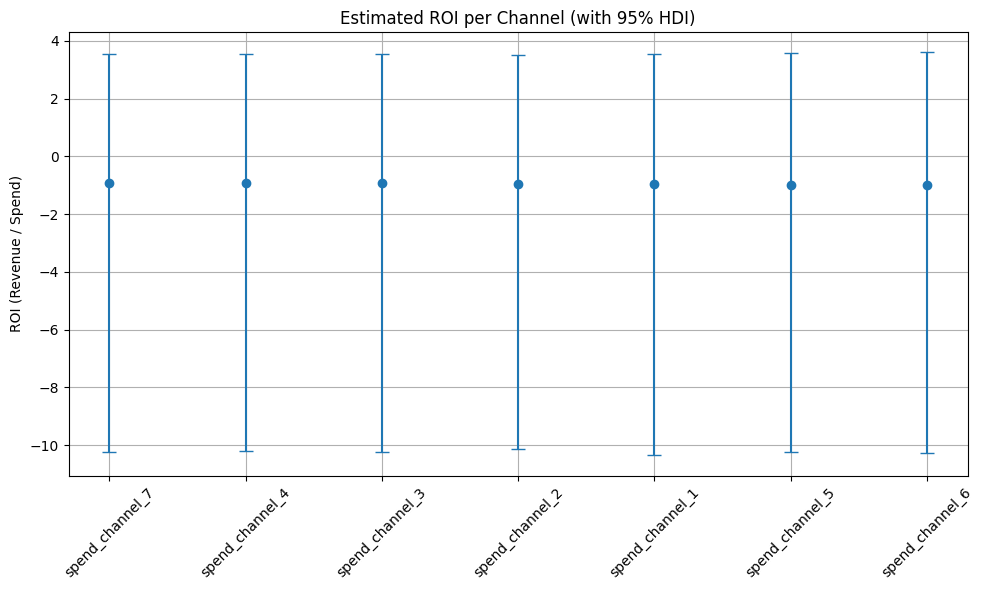

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(roi_df["Channel"], roi_df["ROI Mean"],
             yerr=[roi_df["ROI Mean"] - roi_df["ROI 2.5%"],
                   roi_df["ROI 97.5%"] - roi_df["ROI Mean"]],
             fmt='o', capsize=5)
plt.title("Estimated ROI per Channel (with 95% HDI)")
plt.xticks(rotation=45)
plt.ylabel("ROI (Revenue / Spend)")
plt.grid(True)
plt.tight_layout()
plt.show()


None of the seven channels offer a clearly positive return on investment based on the projected ROI, hence all have great uncertainty... again!!
